# Cirrhosis Classification

Notebook for Cirrhosis classification model.


In [129]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    f1_score,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 42

In [4]:
raw_train = pd.read_csv("./KaggleData/train.csv")
raw_test = pd.read_csv("./KaggleData/test.csv")
sample_sub = pd.read_csv("./KaggleData/sample_submission.csv")

## Explore data


In [5]:
raw_train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,15000.0,7499.500000,4330.271354,0.00,3749.75,7499.50,11249.25,14999.00
N_Days,15000.0,1992.302867,1302.883769,7.00,1097.00,1832.00,2689.00,25202.00
Age,15000.0,19364.762333,3662.457142,338.00,16718.00,19724.00,22546.00,34076.00
Bilirubin,15000.0,1.863101,2.844293,0.30,0.60,0.90,1.80,51.00
Cholesterol,6493.0,328.428153,182.440088,98.00,242.00,280.00,358.00,3472.00
Albumin,15000.0,3.521811,0.373854,1.96,3.29,3.58,3.77,4.64
Copper,8293.0,74.542823,73.391663,4.00,31.00,52.00,86.00,588.00
Alk_Phos,8379.0,1664.835565,1857.034176,10.60,722.00,1074.00,1689.00,18176.00
SGOT,8376.0,105.973372,50.078133,20.60,71.00,97.65,130.20,601.00
Tryglicerides,6444.0,110.501653,51.503708,11.00,80.00,99.00,133.00,1000.00


In [6]:
raw_train.describe(include="object").T

,count,unique,top,freq
Drug,8394,3,D-penicillamine,4515
Sex,15000,2,F,14378
Ascites,8385,2,N,8005
Hepatomegaly,8386,2,N,4535
Spiders,8378,2,N,6651
Edema,15000,3,N,13850
Status,15000,3,C,10108


## Checking correlation


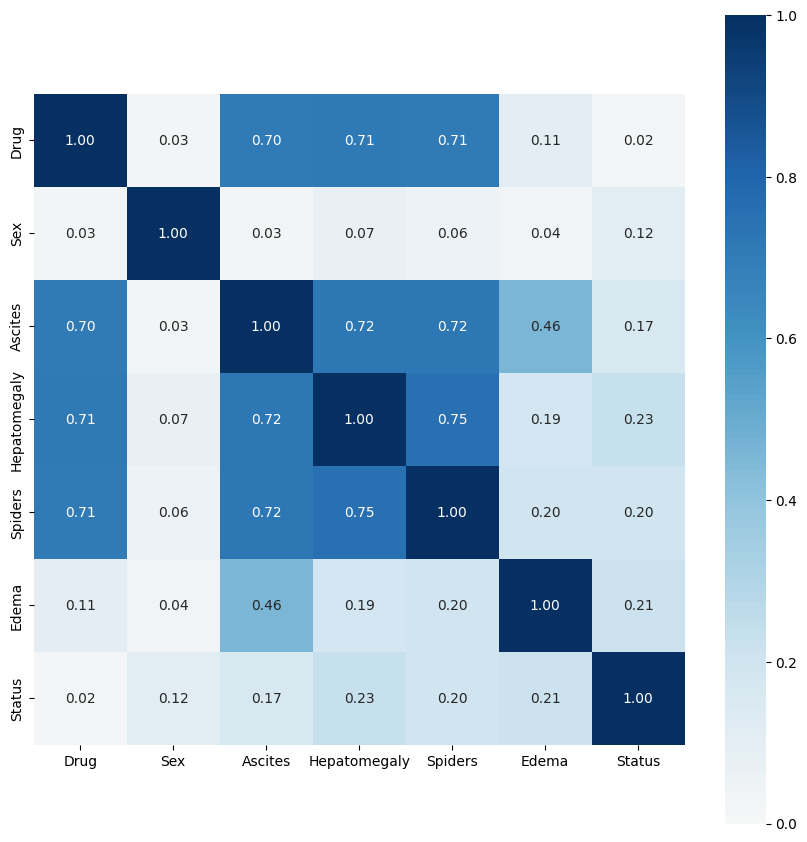

In [7]:
from dython.nominal import associations

cat_corr = associations(
    raw_train.select_dtypes(include=["object", "category"]), cmap="RdBu"
)

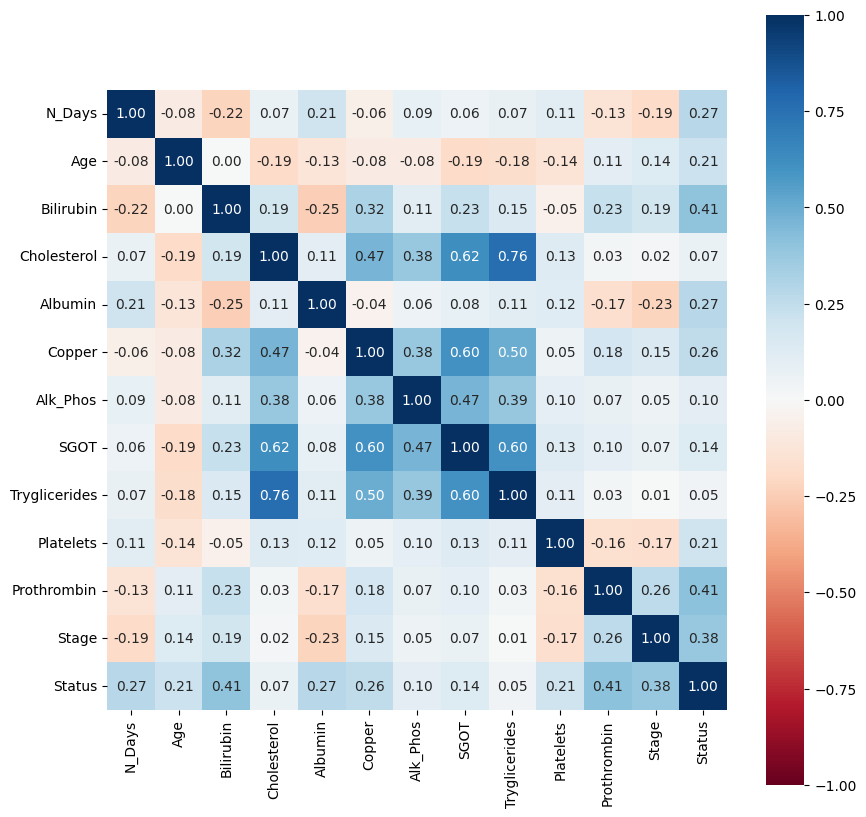

In [8]:
exclude_cols = list(
    raw_train.select_dtypes(include=["object", "category"]).columns.drop("Status")
)
exclude_cols += ["id"]

num_corr = associations(
    raw_train.drop(exclude_cols, axis=1), figsize=(10, 10), cmap="RdBu"
)

Text(0, 0.5, 'Correlation with target')

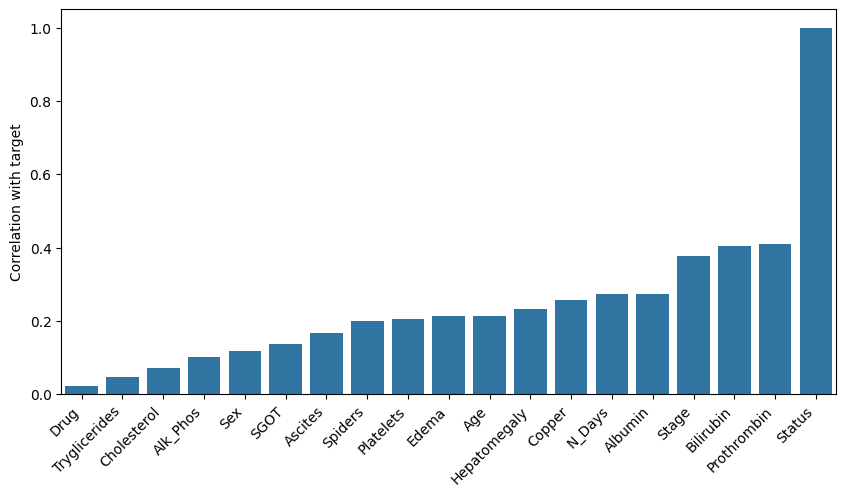

In [9]:
train_corr = pd.concat(
    [cat_corr["corr"]["Status"], num_corr["corr"]["Status"]], axis=0
).sort_values()

plt.figure(figsize=(10, 5))
plt.xticks(rotation=45, ha="right")
sns.barplot(train_corr)
plt.ylabel("Correlation with target")

## Handle missing values

In [124]:
def preprocess_X(raw_data, random_seed=0):
    """
    Preprocess data with numeric and categorical imputation.

    Parameters:
    -----------
    raw_data : pd.DataFrame
        The raw dataset to preprocess
    random_seed : int, default=0
        Random seed for reproducibility

    Returns:
    --------
    pd.DataFrame: processed data
    """

    # Mapping dictionary embedded in function
    mapping_dict = {
        "Drug": {"Placebo": 0, "D-penicillamine": 1},
        "Sex": {"F": 0, "M": 1},
        "Ascites": {"N": 0, "Y": 1},
        "Hepatomegaly": {"N": 0, "Y": 1},
        "Spiders": {"N": 0, "Y": 1},
        "Edema": {"N": 0, "S": 1, "Y": 2},
    }

    # Create a copy and drop id
    data = raw_data.drop(["id"], axis=1)

    # Handle numeric features
    numeric_data = data.select_dtypes(include=["number"])
    num_imputer = IterativeImputer(max_iter=10, random_state=random_seed)
    num_imputer.set_output(transform="pandas")
    filled_numeric = num_imputer.fit_transform(numeric_data)

    # Handle categorical features
    categorical_data = data.select_dtypes(include=["object"])

    # Map categorical values to numeric
    # For each key in the mapping dictionary
    for col in mapping_dict.keys():
        categorical_data[col] = (
            categorical_data[col].map(mapping_dict[col]).astype(np.float32)
        )

    # Impute categorical features
    cat_imputer = IterativeImputer(
        estimator=DecisionTreeClassifier(), max_iter=10, random_state=random_seed
    )
    cat_imputer.set_output(transform="pandas")
    filled_categorical = cat_imputer.fit_transform(categorical_data).astype(np.int8)

    # Combine numeric and categorical data
    filled_data = pd.concat([filled_numeric, filled_categorical], axis=1).round(1)

    return filled_data

In [125]:
def preprocess_y(raw_data):
    """
    Preprocess the target data.

    Parameters:
    -----------
    raw_data : pd.Series
        The raw Series to preprocess

    Returns:
    --------
    pd.Series: processed target data
    """
    target_mapping = {"D": 0, "C": 1, "CL": 2}
    return raw_data.map(target_mapping)

In [126]:
for col in raw_train.select_dtypes(include=["object", "category"]).columns:
    print(raw_train[col].value_counts())

Drug
D-penicillamine    4515
Placebo            3878
Name: count, dtype: int64
Sex
F    14378
M      622
Name: count, dtype: int64
Ascites
N    8005
Y     380
Name: count, dtype: int64
Hepatomegaly
N    4535
Y    3851
Name: count, dtype: int64
Spiders
N    6651
Y    1727
Name: count, dtype: int64
Edema
N    13850
S      811
Y      339
Name: count, dtype: int64
Status
C     10108
D      4520
CL      372
Name: count, dtype: int64


In [127]:
raw_train["Drug"] = raw_train["Drug"].replace("N", np.NaN)

In [183]:
raw_X = raw_train.drop("Status", axis=1)
raw_y = raw_train["Status"]

raw_X_train, raw_X_val, raw_y_train, raw_y_val = train_test_split(
    raw_X, raw_y, test_size=0.2, random_state=RANDOM_SEED
)

X_train = preprocess_X(raw_X_train, random_seed=RANDOM_SEED)
y_train = preprocess_y(raw_y_train)

X_val = preprocess_X(raw_X_val, random_seed=RANDOM_SEED)
y_val = preprocess_y(raw_y_val)

## EDA after handling missing values

EDA the data after handling the missing values to see the distribution of the data.


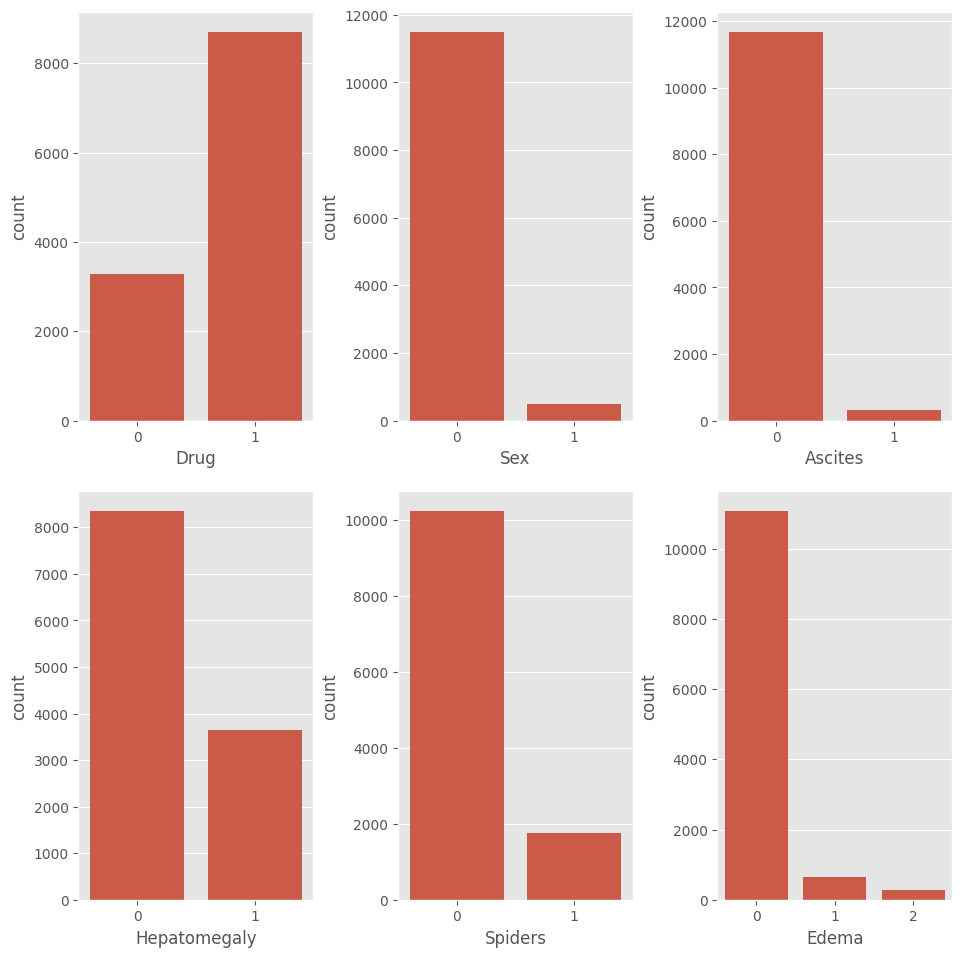

In [184]:
import seaborn as sns
from matplotlib import pyplot as plt

cat_cols = raw_train.drop("Status", axis=1).select_dtypes(include=["object", "category"]).columns

fig, ax = plt.subplots(2, 3, figsize=(10, 10))
plt.tight_layout(pad=3.0)
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=X_train, ax=ax[i // 3, i % 3])

In [185]:
y_train.value_counts()

Status
1    8072
0    3621
2     307
Name: count, dtype: int64

The distribution of the categorical features is very imbalanced in every feature.


In [208]:
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import PowerTransformer, StandardScaler

def preprocess_num_data(num_data: pd.DataFrame, plot: bool = False) -> pd.DataFrame:
    """
    Preprocess numerical data by scaling it.

    Parameters:
    -----------
    num_data : pd.DataFrame
        The numerical data to preprocess

    Returns:
    --------
    pd.DataFrame: preprocessed numerical data
    """


    num_data = num_data.copy()
    num_cols = num_data.columns
    
    def data_ploter(data, title):
        if not plot:
            return

        fig, ax = plt.subplots(4, 3, figsize=(15, 15))
        fig.suptitle(title)
        fig.tight_layout(pad=3.0)
        for i, col in enumerate(num_cols):
            sns.histplot(data[col], ax=ax[i // 3, i % 3])
    
    def get_skewed_cols(data):
        num_skew_abs = data.skew().abs().sort_values(ascending=False)
        skewed_cols = num_skew_abs[num_skew_abs > 0.5].index
        return skewed_cols
    
    data_ploter(num_data, "Before Scaling")

    # Scale the data
    skewed_cols = get_skewed_cols(num_data)
    num_data[skewed_cols] = num_data[skewed_cols].apply(lambda x: winsorize(x, limits=0.01))

    data_ploter(num_data, "After Winsorizing")

    skewed_cols = get_skewed_cols(num_data)
    pt = PowerTransformer()
    pt.set_output(transform="pandas")
    num_data[skewed_cols] = pt.fit_transform(num_data[skewed_cols])

    ss = StandardScaler()
    ss.set_output(transform="pandas")
    num_data = ss.fit_transform(num_data)

    data_ploter(num_data, "After Power Transforming & Standard Scaling")

    return num_data    

In [209]:
num_cols = raw_train.drop(["Status", "id"], axis=1).select_dtypes(include=["number"]).columns

X_scaled_train = X_train.copy()
X_scaled_train[num_cols] = preprocess_num_data(X_train[num_cols])
X_scaled_train[num_cols]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
9839,0.234648,0.824953,-1.007855,-0.815017,-0.316057,-0.764620,-0.963682,-1.279063,0.038356,1.153558,-0.375119,-0.023558
9680,-0.167441,-1.853135,1.656805,-0.969123,-1.119764,2.001237,0.595299,1.657892,-0.552222,-1.359144,0.691263,1.107223
7093,0.230026,-1.133693,-1.007855,-0.126724,0.487649,-0.653606,-0.436708,-0.871245,0.670134,-1.359144,1.358369,1.107223
11293,-0.516842,-1.408013,-1.366489,-1.775474,1.291355,0.101525,-2.611539,-1.911934,-1.695355,-0.282272,-1.177346,-1.154338
820,0.011882,-0.199318,-1.007855,0.068402,-0.316057,0.231147,0.368732,0.052601,0.020140,0.368339,0.934832,-0.023558
...,...,...,...,...,...,...,...,...,...,...,...,...
5191,-1.081614,0.530475,1.468767,-0.689713,1.023453,2.672235,0.958952,0.052601,0.250081,-1.269405,-1.177346,1.107223
13418,-0.289454,-1.293872,-0.705761,0.359098,-0.316057,-0.165180,0.217002,0.119045,0.117436,0.301034,-0.960856,-1.154338
5390,-0.806161,0.497241,-0.705761,0.015888,0.219747,0.155815,0.333604,-0.037140,0.078112,0.177643,0.127476,-0.023558
860,1.387302,0.578420,-0.448705,-0.471046,0.219747,-0.966579,-0.336548,-0.751345,-0.244976,0.132773,-0.960856,-2.285119


In [236]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_SEED)
model = GradientBoostingClassifier(
    learning_rate=0.047831988317386595,
    max_depth=4,
    max_features="log2",
    min_samples_leaf=10,
    min_samples_split=12,
    n_estimators=468,
    subsample=0.6763658784493454,
    random_state=RANDOM_SEED,
)

In [237]:
train_loss = []
val_loss = []

for train_index, val_index in rskf.split(X_scaled_train, y_train):
    X_train_fold, X_val_fold = X_scaled_train.iloc[train_index], X_scaled_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    smote = SMOTE(random_state=RANDOM_SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    model.fit(X_train_fold, y_train_fold)

    y_pred_train = model.predict_proba(X_train_fold)
    y_pred_val = model.predict_proba(X_val_fold)

    train_loss.append(log_loss(y_train_fold, y_pred_train))
    val_loss.append(log_loss(y_val_fold, y_pred_val))

<Axes: >

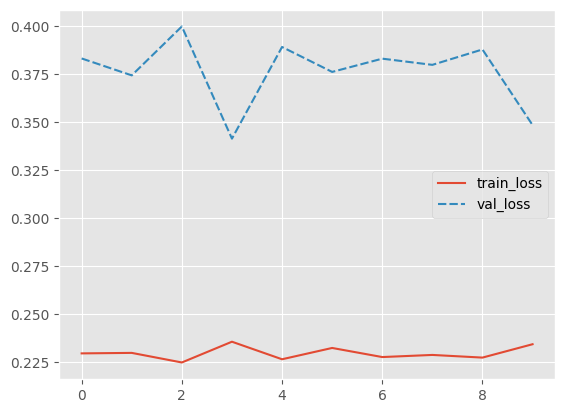

In [238]:
cv_loss = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})
cv_loss

sns.lineplot(data=cv_loss)

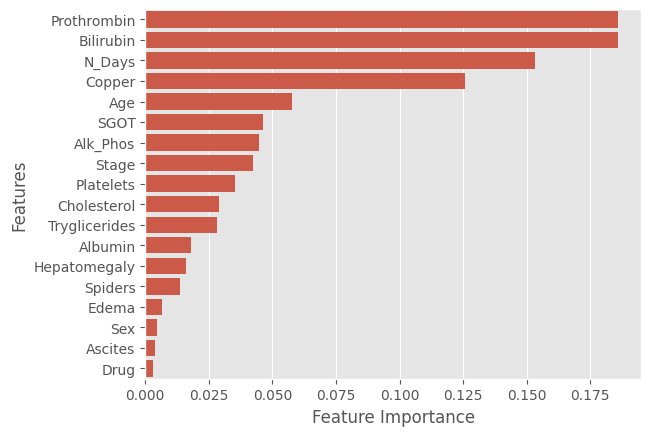

In [239]:
feature_imp = pd.Series(
    model.feature_importances_, index=X_train.columns, name="feature_importance"
).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features");

## Testing on Test dataset

In [240]:
X_scaled_val = X_val.copy()
X_scaled_val[num_cols] = preprocess_num_data(X_scaled_val[num_cols])

In [241]:
y_pred_val = model.predict_proba(X_scaled_val)
log_loss(y_val, y_pred_val)

0.35711468925174966

## Predicting on real validation set

In this step we will get the prediction of the target on real data from test set. But we also need to clean and preprocess the test data as the test dataset is also dirty.


In [222]:
X_test = preprocess_X(raw_test, random_seed=RANDOM_SEED)
X_test

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema
0,3099.0,20662.0,0.5,260.0,3.9,58.0,804.0,85.2,174.0,256.0,10.3,3.0,0,0,0,0,0,0
1,3030.0,22646.0,0.7,283.5,4.2,41.0,1578.9,85.5,100.1,269.0,10.0,3.0,1,0,0,0,0,0
2,4556.0,17031.0,0.8,235.0,3.0,39.0,1009.0,139.5,67.0,257.2,11.0,2.0,1,0,0,1,1,0
3,2294.0,15009.0,0.6,223.0,3.0,29.0,884.0,65.1,85.0,228.0,9.7,3.0,0,0,0,1,0,0
4,1150.0,12053.0,2.1,344.7,3.3,82.9,1494.4,117.7,115.0,256.0,10.9,2.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3358.0,22646.0,1.3,232.0,3.3,67.0,1345.0,138.0,106.0,173.0,10.2,4.0,0,0,0,1,0,0
9996,2537.0,17525.0,2.9,318.2,3.0,88.9,1627.2,117.5,111.6,76.0,10.6,3.0,1,0,0,0,0,0
9997,708.0,22646.0,3.4,344.7,2.6,117.1,1804.2,125.6,120.8,225.0,11.1,4.0,0,0,0,1,1,1
9998,2504.0,19916.0,2.1,325.4,3.4,57.0,1828.0,71.3,115.4,474.0,10.4,2.0,0,0,0,1,1,0


In [242]:
X_scaled_test = X_test.copy()
X_scaled_test[num_cols] = preprocess_num_data(X_scaled_test[num_cols])

In [243]:
submit_pred = model.predict_proba(X_scaled_test)
# Reorder the columns from {"D": 0, "C": 1, "CL": 2} to {"C": 0, "CL": 1, "D": 2}
submit_pred = submit_pred[:, [1, 2, 0]]
submit_pred = pd.DataFrame(submit_pred, columns=["Status_C", "Status_CL", "Status_D"])
submit_pred = pd.concat([raw_test["id"], submit_pred], axis=1)
submit_pred

,id,Status_C,Status_CL,Status_D
0,15000,0.974885,0.000636,0.024479
1,15001,0.969334,0.002405,0.028261
2,15002,0.804420,0.001116,0.194464
3,15003,0.989460,0.001698,0.008841
4,15004,0.835695,0.114795,0.049509
...,...,...,...,...
9995,24995,0.765655,0.004082,0.230263
9996,24996,0.457790,0.220823,0.321387
9997,24997,0.013363,0.003189,0.983448
9998,24998,0.780881,0.012533,0.206586


In [244]:
submit_pred.to_csv("submission.csv", index=False)